# Model CNN Pytorch - Emotion Recognition

## Mengimpor Pustaka

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

Pada bagian kode di atas, kita mengimpor pustaka yang diperlukan untuk proyek kita. Kita memerlukan pustaka PyTorch untuk membuat dan melatih model kita, kita menggunakan DataLoader, datasets, dan transforms dari torchvision untuk memuat dan mengubah data kita. torch.nn.functional digunakan untuk menerapkan fungsi seperti fungsi aktivasi.

## Mendefinisikan Model

In [42]:
class EmotionRecognitionModel(nn.Module):
    def __init__(self):
        super(EmotionRecognitionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*1*1, 1024)
        self.fc2 = nn.Linear(1024, 8)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.avg_pool2d(x, x.shape[2:])
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = EmotionRecognitionModel()

Kode di atas mendefinisikan struktur model kita. Model ini adalah contoh dari model Convolutional Neural Networks (CNN) yang terdiri dari dua lapisan konvolusi (conv1 dan conv2), dan dua lapisan penuh terhubung (fc1 dan fc2). Fungsi forward mendefinisikan bagaimana data melewati model kita.

## Menampilkan Ringkasan Model

In [43]:
from torchsummary import summary
summary(model, (1, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Linear-3                 [-1, 1024]          66,560
            Linear-4                    [-1, 8]           8,200
Total params: 93,576
Trainable params: 93,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.76
Params size (MB): 0.36
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


Fungsi summary dari pustaka torchsummary menampilkan ringkasan model kita, termasuk jumlah parameter dan ukuran output di setiap lapisan model.

## Persiapan Dataset dan DataLoader

In [46]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.ImageFolder(root='dataset/kaggle', transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = datasets.ImageFolder(root='dataset/kaggle', transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

Kode di atas digunakan untuk persiapan dataset dan dataloader untuk pelatihan dan pengujian model. Dataset diambil dari folder 'dataset/kaggle'. Transformasi yang diberlakukan pada gambar adalah: mengubah gambar menjadi skala abu-abu (transforms.Grayscale), mengubah ukuran gambar menjadi 32x32 (transforms.Resize), mengubah gambar ke tensor (transforms.ToTensor), dan menormalkan nilai pixel gambar (transforms.Normalize).

## Visualisasi Distribusi Label

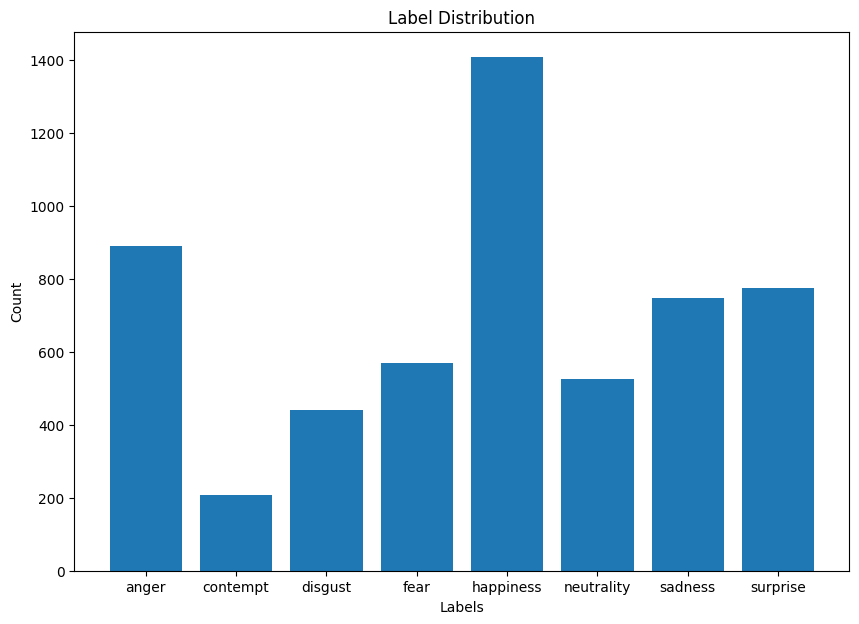

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Get labels from trainset
labels = np.array(trainset.targets)

# Get unique labels and counts
unique_labels, counts = np.unique(labels, return_counts=True)

# Plotting
plt.figure(figsize=(10,7))
plt.bar(trainset.classes, counts)
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Kode di atas digunakan untuk visualisasi distribusi label dalam dataset kita. Menggunakan matplotlib, kita dapat membuat plot batang yang menunjukkan jumlah sampel untuk setiap label.

## Membuat Kriteria dan Optimizer

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training and Validation phase

In [52]:
device = torch.device("cpu")
model = model.to(device)

loss_values = []
val_loss_values = []

patience = 5  # Number of epochs to wait for improvement in validation loss
patience_counter = 0  # Counter to keep track of epochs without improvement
best_val_loss = np.inf  # Keep track of best validation loss

for epoch in range(50):  # loop over the dataset multiple times

    # Training phase
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_values.append(running_loss / len(trainloader))
    print('Epoch %d training loss: %.3f' % (epoch + 1, loss_values[-1]))

    # Validation phase
    val_running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
    
    val_loss_values.append(val_running_loss / len(testloader))
    print('Epoch %d validation loss: %.3f' % (epoch + 1, val_loss_values[-1]))

    # Check for improvement in validation loss
    if val_loss_values[-1] < best_val_loss:  # Loss improved
        best_val_loss = val_loss_values[-1]
        patience_counter = 0  # Reset the counter
    else:  # Loss did not improve
        patience_counter += 1  # Increment the counter

    if patience_counter >= patience:
        print(f"Stopping training because validation loss has not improved in {patience} epochs.")
        break

print('Finished Training')

Epoch 1 training loss: 1.960
Epoch 1 validation loss: 1.958
Epoch 2 training loss: 1.957
Epoch 2 validation loss: 1.954
Epoch 3 training loss: 1.953
Epoch 3 validation loss: 1.951
Epoch 4 training loss: 1.950
Epoch 4 validation loss: 1.948
Epoch 5 training loss: 1.948
Epoch 5 validation loss: 1.945
Epoch 6 training loss: 1.945
Epoch 6 validation loss: 1.944
Epoch 7 training loss: 1.944
Epoch 7 validation loss: 1.943
Epoch 8 training loss: 1.942
Epoch 8 validation loss: 1.941
Epoch 9 training loss: 1.942
Epoch 9 validation loss: 1.941
Epoch 10 training loss: 1.941
Epoch 10 validation loss: 1.941
Epoch 11 training loss: 1.941
Epoch 11 validation loss: 1.941
Epoch 12 training loss: 1.941
Epoch 12 validation loss: 1.939
Epoch 13 training loss: 1.940
Epoch 13 validation loss: 1.939
Epoch 14 training loss: 1.940
Epoch 14 validation loss: 1.939
Epoch 15 training loss: 1.940
Epoch 15 validation loss: 1.939
Epoch 16 training loss: 1.940
Epoch 16 validation loss: 1.938
Epoch 17 training loss: 1.

## Visualization

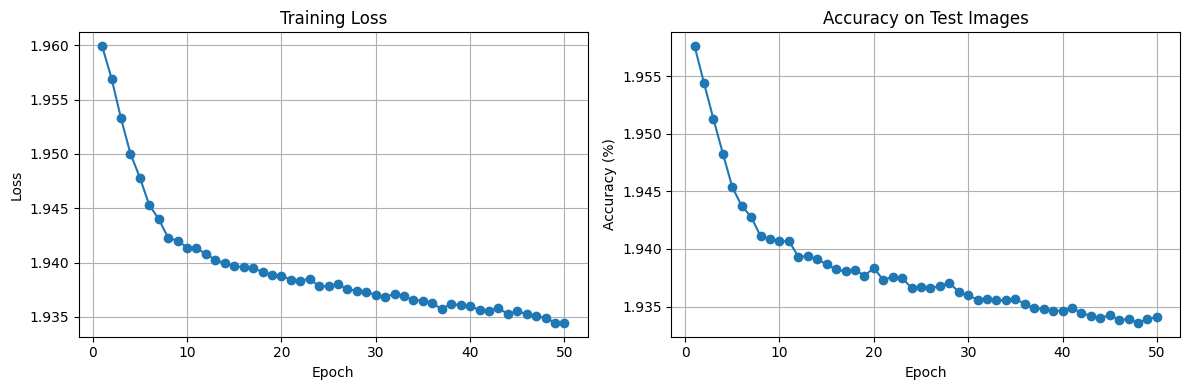

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
# Plotting the accuracy values
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plotting the accuracy values
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy on Test Images')
plt.grid(True)


plt.tight_layout()
plt.show()

## Save Model

In [55]:
torch.save(model.state_dict(), 'model/pytorch/emotion_recognition_model.pth')

## Use the model

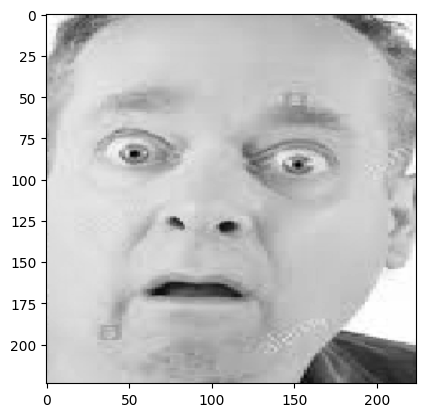

happiness: 22.374175488948822%
surprise: 21.347565948963165%
anger: 14.605419337749481%
fear: 12.675774097442627%
sadness: 11.148933321237564%
disgust: 8.74893069267273%
neutrality: 7.280831038951874%
contempt: 1.8183736130595207%


In [63]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import torch.nn.functional as F

def predict_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    model = EmotionRecognitionModel()
    model.load_state_dict(torch.load('model/pytorch/emotion_recognition_model.pth'))
    model.eval()

    # Load and display image
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')  # use cmap='gray' for grayscale images
    plt.show()

    # Predict emotion
    image_transformed = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image_transformed)
        probabilities = F.softmax(output, dim=1)  # compute the probability
        
    # Translate predicted to emotion label
    emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

    # Pair each emotion with its corresponding probability and sort them
    emotion_probability_pair = [(emotion, probability.item()*100) for emotion, probability in zip(emotion_labels, probabilities[0])]
    emotion_probability_pair.sort(key=lambda x: x[1], reverse=True)

    # Print each emotion with its corresponding probability
    for emotion, probability in emotion_probability_pair:
        print(f"{emotion}: {probability}%")


# Test the function
predict_image('dataset/kaggle/fear/2Q__ (5)_face.png')